# Bayesian Personalized Ranking (BPR)

This notebook demonstrates:
1. BPR algorithm for implicit feedback
2. Comparison with ALS
3. Two-stage recommender system (ALS → BPR)
4. Evaluation metrics for ranking
5. Embedding visualizations

In [62]:
# !pip install implicit

In [63]:
import numpy as np
import pandas as pd
import time
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from typing import List, Set

from implicit.als import AlternatingLeastSquares
from implicit.bpr import BayesianPersonalizedRanking

In [64]:
# For reproducibility
SEED = 2025
np.random.seed(SEED)

## 1. Load MovieLens Data

We'll use the MovieLens 100K dataset with implicit feedback (rating >= 4).

In [65]:
ratings = pd.read_csv(
    "https://files.grouplens.org/datasets/movielens/ml-100k/u.data",
    sep="\t",
    names=["user", "item", "rating", "timestamp"]
)

# Convert to implicit feedback: rating >= 4 → interaction
ratings["implicit"] = (ratings["rating"] >= 4).astype(int)
df = ratings[ratings["implicit"] == 1].copy()

print(f"Total interactions: {len(df):,}")
print(f"Original data shape: {ratings.shape}")
df.head()

Total interactions: 55,375
Original data shape: (100000, 5)


,user,item,rating,timestamp,implicit
5,298,474,4,884182806,1
7,253,465,5,891628467,1
11,286,1014,5,879781125,1
12,200,222,5,876042340,1
16,122,387,5,879270459,1


In [66]:
# Encode to 0-based index
user2id = {uid: i for i, uid in enumerate(df.user.unique())}
item2id = {iid: i for i, iid in enumerate(df.item.unique())}
df["uid"] = df["user"].map(user2id)
df["iid"] = df["item"].map(item2id)

n_users = df["uid"].nunique()
n_items = df["iid"].nunique()

print(f"Number of users: {n_users}")
print(f"Number of items: {n_items}")
print(f"Sparsity: {1 - len(df) / (n_users * n_items):.2%}")

Number of users: 942
Number of items: 1447
Sparsity: 95.94%


## 2. Train/Validation/Test Split

We use **temporal leave-one-out splitting**:
- Training: All interactions except last 2
- Validation: Second-to-last interaction
- Test: Last interaction

In [47]:
df_train = []
df_val = []
df_test = []

for uid, user_data in df.groupby("uid"):
    user_data = user_data.sort_values("timestamp")
    if len(user_data) < 3:
        continue
    df_train.append(user_data.iloc[:-2])   # All but last two
    df_val.append(user_data.iloc[-2:-1])   # Second-to-last
    df_test.append(user_data.iloc[-1:])    # Last

df_train = pd.concat(df_train)
df_val = pd.concat(df_val)
df_test = pd.concat(df_test)

print(f"Train: {len(df_train):,} interactions")
print(f"Val: {len(df_val):,} interactions")
print(f"Test: {len(df_test):,} interactions")

Train: 53,491 interactions
Val: 942 interactions
Test: 942 interactions


In [48]:
# Create sparse matrix for training
R_train = csr_matrix(
    (
        df_train["implicit"].values,
        (df_train["uid"].values, df_train["iid"].values)
    ),
    shape=(n_users, n_items)
)

# Create test/val item dictionaries {user_id: set(item_ids)}
val_items = df_val.groupby("uid")["iid"].apply(set).to_dict()
test_items = df_test.groupby("uid")["iid"].apply(set).to_dict()

print(f"R_train shape: {R_train.shape}")
print(f"Val users: {len(val_items)}")
print(f"Test users: {len(test_items)}")

R_train shape: (942, 1447)
Val users: 942
Test users: 942


## 3. Evaluation Metrics

We implement ranking metrics:
- **Hit Rate@K**: Did we recommend at least 1 relevant item?
- **NDCG@K**: Normalized Discounted Cumulative Gain (position-aware)
- **MAP@K**: Mean Average Precision (rewards early hits)
- **Recall@K**: Fraction of relevant items found

In [78]:
from abc import ABC, abstractmethod

class BaseRecommender(ABC):
    """Abstract base class for all recommenders."""
    
    @abstractmethod
    def fit(self, R_train):
        pass
    
    @abstractmethod
    def recommend(self, user_id, K=10):
        """Return list of K recommended item IDs."""
        pass

In [67]:
# ============================================================
# Evaluate 
# ============================================================
def recall_at_k(rec_items: List, true_items: Set, K):
    n_hit = len(set(rec_items[:K]) & true_items)
    n_true = len(true_items)
    if n_true == 0:
        return 0.0
    return n_hit / n_true

def hr_at_k(rec_items: List, true_items: Set, K):
    "Hit Rate at k"
    n_hit = len(set(rec_items[:K]) & true_items)
    return 1.0 if n_hit > 0 else 0.0

def ndcg_at_k(rec_items: List, true_items: Set, K):
    dcg = 0.0
    for i, item in enumerate(rec_items[:K]):
        if item in true_items:
            dcg += 1.0 / np.log2(i + 2)  # i + 2 because i starts from 0
    idcg = sum(1.0 / np.log2(i + 2) for i in range(min(len(true_items), K)))
    if idcg == 0:
        return 0.0
    return dcg / idcg

def map_at_k(rec_items: List, true_items: Set, K):
    """MAP@K (Mean Average Precision at K) measures the quality of ranked recommendations by rewarding relevant items appearing earlier in the list.
    
    AP = (1 / position) if hit else 0

    # Hit at position 1 → AP = 1.0
    # Hit at position 5 → AP = 0.2
    # No hit           → AP = 0.0
    """
    hit_count = 0
    precision_score = 0.0
    for i, item in enumerate(rec_items[:K]):
        if item in true_items:
            hit_count += 1
            precision_score += hit_count / (i + 1) # Precision at this position
            #                      ↑ cumulative hits
            #                                 ↑ position (1-indexed)
    if hit_count == 0:
        return 0.0
    return precision_score / min(len(true_items), K) if true_items else 0.0

In [89]:
def evaluate(model: BaseRecommender, test_items: dict, K:int=10):
    """
    Evaluate any recommender that follows BaseRecommender interface.
    """
    recalls, hit_rates, ndcgs, maps = [], [], [], []
    
    for uid, true_items in test_items.items():
        rec_items = model.recommend(uid, K) # Ordered list
        
        recalls.append(recall_at_k(rec_items, true_items, K))
        hit_rates.append(hr_at_k(rec_items, true_items, K))
        ndcgs.append(ndcg_at_k(rec_items, true_items, K))
        maps.append(map_at_k(rec_items, true_items, K))
        
       
    return {
        f"Recall@{K}": np.mean(recalls),
        f"HitRate@{K}": np.mean(hit_rates),
        f"NDCG@{K}": np.mean(ndcgs),
        f"MAP@{K}": np.mean(maps)
    }

## 4. Train BPR Model

BPR learns to rank items using **pairwise comparisons**:
- For each user, compare observed vs. non-observed items
- Optimize: `score(user, observed_item) > score(user, non_observed_item)`

In [111]:
# Train BPR
bpr = BayesianPersonalizedRanking(
    factors=64,
    learning_rate=0.05,
    regularization=0.01,
    iterations=30,
    verify_negative_samples=True,
    random_state=SEED
)

start = time.time()
bpr.fit(R_train)
bpr_time = time.time() - start

print(f"\nBPR training time: {bpr_time:.2f}s")

100%|██████████| 30/30 [00:00<00:00, 455.70it/s, train_auc=92.96%, skipped=23.10%]


BPR training time: 0.07s


With `verify_negative_samples=True`:

BPR checks if the randomly sampled negative item is actually in the user's interaction history
If it is, the sample is skipped (not used for training)
```Python
User 42 liked items: [10, 25, 67, 103]

# Random sampling picks:
triple = (user=42, positive=10, negative=67)  ❌ WRONG!
#                                    ↑
#                          User actually liked item 67!

# With verify_negative_samples=True:
# This triple is SKIPPED because 67 is in user's history
# A new negative sample is drawn

```

**Note:** `train_auc` should be >90%. If lower, increase iterations or adjust learning rate.

In [112]:
def recommend_bpr_only(bpr, R_train, user_id, K=10):
    """BPR-only recommendation (score all items directly)."""
    # Get user vector
    user_vec = bpr.user_factors[user_id]
    
    # Get all item vectors
    all_item_vecs = bpr.item_factors  # (n_items, factors)
    
    # Compute scores for ALL items
    scores = all_item_vecs @ user_vec  # (n_items,)
    
    # Get already-seen items to filter out
    seen_items = set(R_train[user_id].indices)
    
    # Filter out seen items by setting their scores to -inf
    scores_filtered = scores.copy()
    for item in seen_items:
        scores_filtered[item] = -np.inf
    
    # Get top-K items
    top_k_idx = np.argsort(scores_filtered)[::-1][:K]
    
    return np.array(top_k_idx)


def evaluate_bpr_only(bpr, R_train, test_items_dict, K=10):
    """Evaluate BPR-only recommender."""
    hrs, ndcgs, maps, recalls = [], [], [], []
    
    for uid, true_items in test_items_dict.items():
        recs = recommend_bpr_only(bpr, R_train, uid, K)
        
        hrs.append(hr_at_k(recs, true_items, K))
        ndcgs.append(ndcg_at_k(recs, true_items, K))
        maps.append(map_at_k(recs, true_items, K))
        recalls.append(recall_at_k(recs, true_items, K))
    
    return {
        f"HitRate@{K}": np.mean(hrs),
        f"NDCG@{K}": np.mean(ndcgs),
        f"MAP@{K}": np.mean(maps),
        f"Recall@{K}": np.mean(recalls)
    }


# Evaluate BPR-only
print("Evaluating BPR-only...")
bpr_only_results = evaluate_bpr_only(bpr, R_train, test_items, K=10)
print("BPR-only Results:")

pd.DataFrame({"BPR-only": bpr_only_results}).T.round(4)

Evaluating BPR-only...
BPR-only Results:


,HitRate@10,NDCG@10,MAP@10,Recall@10
BPR-only,0.1019,0.0536,0.0391,0.1019


## 5. Hyperparameter Tuning for BPR

In [114]:
import itertools

# Define grid (smaller for faster experimentation)
param_grid = {
    'factors': [32, 64],
    'learning_rate': [0.001, 0.01, 0.05],
    'regularization': [0.001, 0.01],
    'iterations': [20, 30, 50]
}

best_score = 0
best_params = None

print("Starting hyperparameter search...\n")

for factors, lr, reg, iters in itertools.product(
    param_grid['factors'],
    param_grid['learning_rate'],
    param_grid['regularization'],
    param_grid['iterations']
):
    # Train BPR
    bpr_temp = BayesianPersonalizedRanking(
        factors=factors,
        learning_rate=lr,
        regularization=reg,
        iterations=iters,
        verify_negative_samples=True,
        random_state=SEED
    )
    bpr_temp.fit(R_train)
    
    # Evaluate on validation set
    metrics = evaluate_bpr_only(bpr_temp, R_train, val_items, K=10)
    ndcg = metrics['NDCG@10']
    
    if ndcg > best_score:
        best_score = ndcg
        best_params = {
            'factors': factors,
            'learning_rate': lr,
            'regularization': reg,
            'iterations': iters
        }

print(f"Best NDCG@10 on validation: {best_score:.4f}")
print(f"Best params: {best_params}")

Starting hyperparameter search...



100%|██████████| 50/50 [00:00<00:00, 510.91it/s, train_auc=96.83%, skipped=23.21%]

Best NDCG@10 on validation: 0.0595
Best params: {'factors': 32, 'learning_rate': 0.05, 'regularization': 0.001, 'iterations': 20}


In [ ]:
# Tune iterations with early stopping
best_ndcg = 0
best_iteration = 0

for iteration in range(1, 101):
    bpr_temp = BayesianPersonalizedRanking(
        factors=32,
        learning_rate=0.05,
        regularization=0.001,
        iterations=iteration,
        verify_negative_samples=True,
        random_state=SEED
    )
    bpr_temp.fit(R_train)
    
    # Evaluate on validation
    val_metrics = evaluate_bpr_only(bpr_temp, R_train, val_items, K=10)
    val_ndcg = val_metrics['NDCG@10']
    
    if val_ndcg > best_ndcg:
        best_ndcg = val_ndcg
        best_iteration = iteration
    
    # Early stopping: if no improvement in 10 iterations
    if iteration - best_iteration > 10:
        print(f"Early stopping at iteration {iteration}")
        print(f"Best iteration: {best_iteration} with NDCG@10: {best_ndcg:.4f}")
        break


100%|██████████| 38/38 [00:00<00:00, 610.43it/s, train_auc=94.08%, skipped=23.35%]


Early stopping at iteration 38
Best iteration: 27 with NDCG@10: 0.0634


In [129]:
class BPRRecommender(BaseRecommender):
    """BPR-only recommender system."""
    
    def __init__(self, factors=64, learning_rate=0.05, regularization=0.01, iterations=30, random_state=SEED):
        self.model = BayesianPersonalizedRanking(
            factors=factors,
            learning_rate=learning_rate,
            regularization=regularization,
            iterations=iterations,
            verify_negative_samples=True,
            random_state=random_state
        )
        self.fitted = False
        self.R_train = None
    
    def fit(self, R_train):
        self.model.fit(R_train)
        self.R_train = R_train
        self.fitted = True
        return self
    
    def recommend(self, user_id, K=10):
        if not self.fitted:
            raise ValueError("Model not fitted yet. Call 'fit' before 'recommend'.")
        
        return recommend_bpr_only(self.model, self.R_train, user_id, K)

In [ ]:
class ALSRecommender(BaseRecommender):
    """Wrapper for implicit ALS."""
    
    def __init__(self, factors=64, regularization=0.001, iterations=20, 
                 alpha=10, random_state=SEED):
        self.model = AlternatingLeastSquares(
            factors=factors,
            regularization=regularization,
            iterations=iterations,
            random_state=random_state
        )
        self.alpha = alpha  # Store alpha for confidence weighting
        self.R_train = None
    
    def fit(self, R_train):
        self.R_train = R_train
        # Apply confidence weighting: confidence = 1 + alpha * R
        self.model.fit(R_train * self.alpha)
        return self
    
    def recommend(self, user_id, K=10):
        items, _ = self.model.recommend(
            userid=user_id,
            user_items=self.R_train[user_id],  # Use original R_train for filtering
            N=K,
            filter_already_liked_items=True
        )
        return np.array(items)


In [119]:
best_bpr = BPRRecommender(
    factors=best_params['factors'],
    learning_rate=best_params['learning_rate'], 
    regularization=best_params['regularization'],
    iterations=27,
    random_state=SEED).fit(R_train)
best_bpr_results = evaluate(best_bpr, test_items, K=10)

100%|██████████| 27/27 [00:00<00:00, 513.11it/s, train_auc=92.72%, skipped=23.24%]


In [120]:
als_best_params = {'factors': 64, 'regularization': 0.001, 'iterations': 20, 'alpha': 10}

best_als = ALSRecommender(**als_best_params, random_state=SEED).fit(R_train)
best_als_results = evaluate(best_als, test_items, K=10)

100%|██████████| 20/20 [00:00<00:00, 374.41it/s]


In [122]:
pd.DataFrame({"BPR-only": bpr_only_results, 
              "BPR-tune": best_bpr_results,
              "ALS-only": best_als_results
              
}).T.round(4)

,HitRate@10,NDCG@10,MAP@10,Recall@10
BPR-only,0.1019,0.0536,0.0391,0.1019
BPR-tune,0.1072,0.0586,0.0441,0.1072
ALS-only,0.1316,0.0675,0.0484,0.1316


## 6. Two-Stage Recommender: ALS → BPR

**Pipeline:**
1. **Stage 1 (Retrieval)**: ALS retrieves ~C=100 candidates (fast)
2. **Stage 2 (Ranking)**: BPR re-ranks candidates to top-K (precise)

This combines the speed of ALS with the ranking quality of BPR.

In [123]:
# ============================================================
# Two-Stage Recommender (ALS → BPR)
# ============================================================

class TwoStageRecommender(BaseRecommender):
    """Two-stage recommender: ALS retrieval → BPR ranking.
    
    Pipeline:
        Stage 1 (Retrieval): ALS retrieves C candidates (fast)
        Stage 2 (Ranking): BPR re-ranks to top-K (precise)
    """
    
    def __init__(self, als_model, bpr_model, C=100):
        """
        Args:
            als_model: Trained ALS model (for retrieval)
            bpr_model: Trained BPR model (for ranking)
            C: Number of candidates to retrieve (default: 100)
        """
        self.als_model = als_model
        self.bpr_model = bpr_model
        self.C = C
        self.R_train = None
    
    def fit(self, R_train):
        """Store training data (models should already be trained)."""
        self.R_train = R_train
        return self
    
    def recommend(self, user_id, K=10):
        """Two-stage recommendation.
        
        Returns:
            Top-K item IDs after two-stage filtering
        """
        # Stage 1: Retrieve top-C candidates using ALS
        candidates = self._retrieve_candidates(user_id, self.C)
        
        # Stage 2: Re-rank candidates using BPR
        top_k = self._rank_with_bpr(user_id, candidates, K)
        
        return top_k
    
    def _retrieve_candidates(self, user_id, C):
        """Stage 1: Fast retrieval with ALS."""
        items, _ = self.als_model.recommend(
            userid=user_id,
            user_items=self.R_train[user_id],
            N=C,
            filter_already_liked_items=True
        )
        return np.array(items)
    
    def _rank_with_bpr(self, user_id, candidate_items, K):
        """Stage 2: Precision ranking with BPR."""
        user_vec = self.bpr_model.user_factors[user_id]
        item_vecs = self.bpr_model.item_factors[candidate_items]
        
        # Compute scores for candidates
        scores = item_vecs @ user_vec
        
        # Get top-K indices
        top_k_idx = np.argsort(scores)[::-1][:K]
        
        return candidate_items[top_k_idx]


In [130]:
als_recommender = ALSRecommender(
    factors=64,
    regularization=0.001,
    iterations=20,
    alpha=10,
    random_state=SEED
).fit(R_train)

bpr_recommender = BPRRecommender(
    factors=32,
    learning_rate=0.05,
    regularization=0.001,
    iterations=27,
    random_state=SEED
).fit(R_train)

C = 500
two_stage_recommender = TwoStageRecommender(als_model=als_recommender.model, bpr_model=bpr_recommender.model, C=C)
two_stage_recommender.fit(R_train)

print("✓ Recommenders instantiated:")
print(f"  - ALS Recommender")
print(f"  - BPR Recommender")
print(f"  - Two-Stage Recommender (C={C})")

100%|██████████| 27/27 [00:00<00:00, 571.21it/s, train_auc=92.74%, skipped=23.24%]

✓ Recommenders instantiated:
  - ALS Recommender
  - BPR Recommender
  - Two-Stage Recommender (C=500)


In [137]:
# ============================================================
# Evaluate All Three Approaches
# ============================================================

K = 10

print(f"\n{'='*60}")
print(f"Evaluating All Models (K={K})")
print(f"{'='*60}\n")

print("Evaluating ALS-only...")
als_results = evaluate(als_recommender, test_items, K=K)

print("Evaluating BPR-only...")
bpr_results = evaluate(bpr_recommender, test_items, K=K)

print("Evaluating ALS → BPR (two-stage)...")
two_stage_results = evaluate(two_stage_recommender, test_items, K=K)

# ============================================================
# Display Results
# ============================================================

print(f"\n{'='*60}")
print(f"Model Comparison (K={K})")
print(f"{'='*60}")

results_df = pd.DataFrame({
    "ALS-only": als_results,
    "BPR-only": bpr_results,
    "ALS→BPR (Two-Stage)": two_stage_results
}).T
results_df.round(4) 


Evaluating All Models (K=10)

Evaluating ALS-only...
Evaluating BPR-only...
Evaluating ALS → BPR (two-stage)...

Model Comparison (K=10)


,Recall@10,HitRate@10,NDCG@10,MAP@10
ALS-only,0.1316,0.1316,0.0675,0.0484
BPR-only,0.1062,0.1062,0.0577,0.0431
ALS→BPR (Two-Stage),0.1072,0.1072,0.0585,0.0438


## 7. Embedding Visualization

Compare item embeddings learned by ALS vs. BPR.

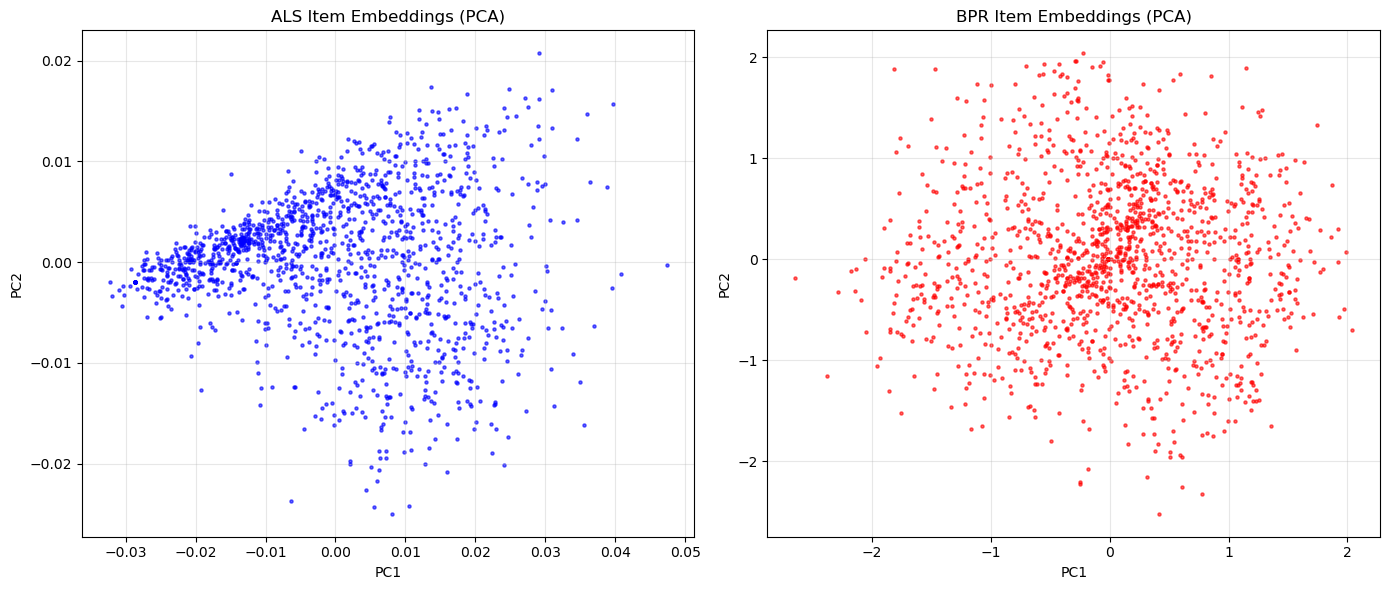

In [134]:
# PCA for dimensionality reduction
pca = PCA(n_components=2, random_state=SEED)

# ALS embeddings
X_als = pca.fit_transform(als_recommender.model.item_factors)

# BPR embeddings (refit PCA for fair comparison)
X_bpr = pca.fit_transform(bpr_recommender.model.item_factors)

# Plot side-by-side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# ALS
ax1.scatter(X_als[:, 0], X_als[:, 1], s=5, alpha=0.6, c='blue')
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
ax1.set_title('ALS Item Embeddings (PCA)')
ax1.grid(alpha=0.3)

# BPR
ax2.scatter(X_bpr[:, 0], X_bpr[:, 1], s=5, alpha=0.6, c='red')
ax2.set_xlabel('PC1')
ax2.set_ylabel('PC2')
ax2.set_title('BPR Item Embeddings (PCA)')
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

### Colored by Popularity

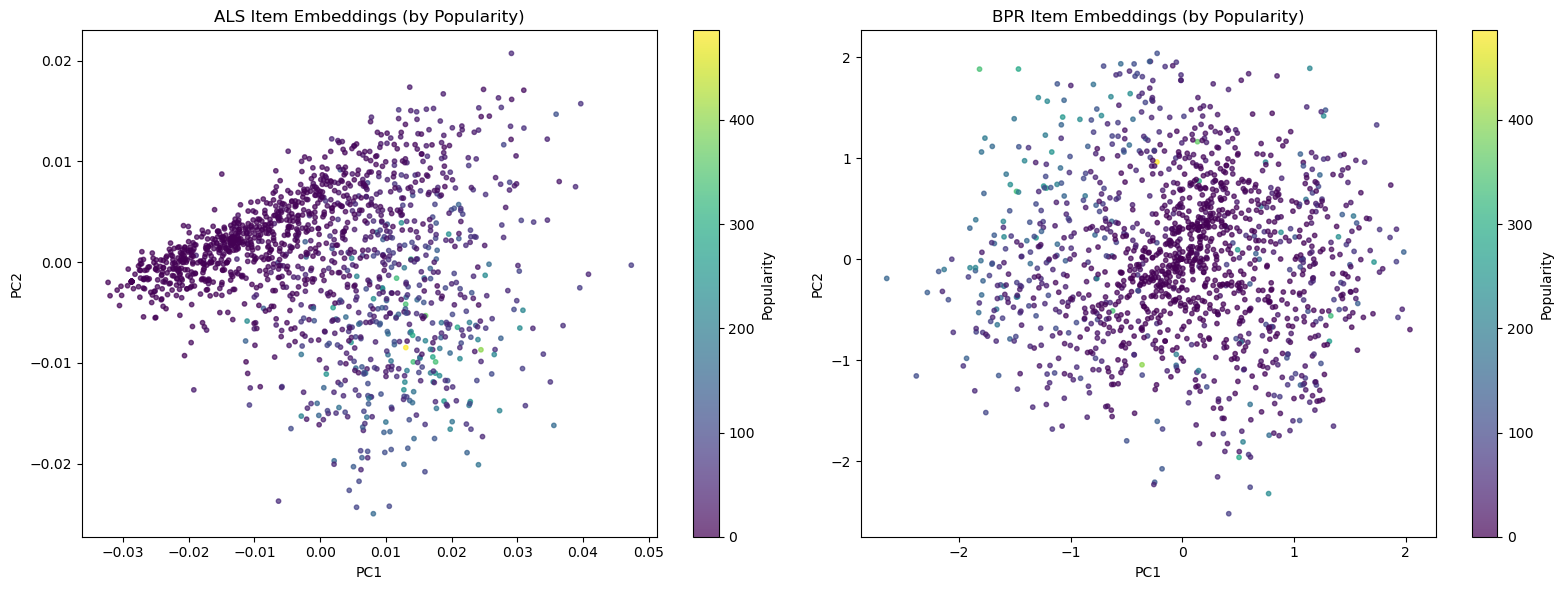


PC1-Popularity Correlation:
  ALS: 0.503
  BPR: -0.108

Interpretation:
  > 0.5  → Strong popularity bias (PC1 mainly captures popularity)
  < 0.5  → Learning personalized patterns beyond popularity


In [135]:
# Calculate item popularity
item_popularity = np.array(R_train.sum(axis=0)).flatten()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# ALS colored by popularity
scatter1 = ax1.scatter(X_als[:, 0], X_als[:, 1], 
                       s=10, alpha=0.7, c=item_popularity, cmap='viridis')
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
ax1.set_title('ALS Item Embeddings (by Popularity)')
plt.colorbar(scatter1, ax=ax1, label='Popularity')

# BPR colored by popularity
scatter2 = ax2.scatter(X_bpr[:, 0], X_bpr[:, 1], 
                       s=10, alpha=0.7, c=item_popularity, cmap='viridis')
ax2.set_xlabel('PC1')
ax2.set_ylabel('PC2')
ax2.set_title('BPR Item Embeddings (by Popularity)')
plt.colorbar(scatter2, ax=ax2, label='Popularity')

plt.tight_layout()
plt.show()

# Correlation analysis
pca_als = PCA(n_components=2).fit_transform(als.item_factors)
pca_bpr = PCA(n_components=2).fit_transform(bpr.item_factors)

corr_als = np.corrcoef(pca_als[:, 0], item_popularity)[0, 1]
corr_bpr = np.corrcoef(pca_bpr[:, 0], item_popularity)[0, 1]

print(f"\nPC1-Popularity Correlation:")
print(f"  ALS: {corr_als:.3f}")
print(f"  BPR: {corr_bpr:.3f}")
print(f"\nInterpretation:")
print(f"  > 0.5  → Strong popularity bias (PC1 mainly captures popularity)")
print(f"  < 0.5  → Learning personalized patterns beyond popularity")

## 8. Key Takeaways

### BPR Advantages:
- ✓ **Ranking-optimized**: Directly learns to rank items (pairwise loss)
- ✓ **Better top-K quality**: Often improves NDCG/MAP over pointwise methods
- ✓ **Implicit feedback**: Designed for binary interactions

### BPR Limitations:
- ✗ **Slower training**: SGD vs. closed-form ALS
- ✗ **Hyperparameter sensitive**: Requires tuning learning rate
- ✗ **Not for retrieval**: Too slow to score millions of items

### Two-Stage Strategy:
```
ALS (fast retrieval) → BPR (precise ranking)
     ↓                       ↓
  ~100 candidates         Top-10 results
```

### When to Use:
- **Use BPR** when ranking quality matters (e.g., homepage recommendations)
- **Use ALS** when speed is critical (e.g., real-time retrieval)
- **Use Both** for production systems (two-stage architecture)

## 9. Further Exploration

Try these experiments:
1. **Negative sampling strategies**: Popularity-weighted vs. uniform
2. **Different factors**: How does embedding size affect results?
3. **Learning rate schedules**: Decay learning rate over time
4. **Hard negative mining**: Sample items similar to positive but not clicked
5. **Feature-based BPR**: Incorporate item/user features